# Convolutional Neural Network Implementation using Pytorch

### [ 1 ] Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

from torchmetrics import Recall, Precision, Accuracy

import matplotlib.pyplot as plt
import numpy as np

### [ 2 ] Device Configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### [ 3 ] Loading Images

<hr />

Desired directory structure: 


```sql
image_train/
    ├── class_name_a/
    │   ├── 75cbf18.jpg
    │   └── 741.jpg
    ├── class_name_b/
    │   ├── 75cbf18.jpg
    │   └── 741.jpg
    └── ...

image_test/
    ├── class_name_a/
    │   ├── 75cbf18.jpg
    │   └── 741.jpg
    ├── class_name_b/
    │   ├── 75cbf18.jpg
    │   └── 741.jpg
    └── ...
```

<hr />

- Main folders: `image_train` and `image_test`
- Inside each main folder: one folder per category
- Inside each class folder: image files 

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally (use for data augmentation when needed)
    transforms.RandomRotation(45), # Randomly rotate the image by 45 degrees (use for data augmentation when needed)
    transforms.ToTensor(), # Parse to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize the tensor with mean (for each # of channels) and std (for each # of channels)
    transform.Resize((128, 128)) # Resize to 128x128 or 28x28 depending on the sdataset
])

dataset_train = ImageFolder('data/train', transform=train_transforms)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [ ]:
test_transforms = transforms.Compose([
    # do not apply any data augmentation to the test dataset
    transforms.ToTensor(),
    transform.resize((128, 128))
])

dataset_test = ImageFolder('data/test', transform=test_transforms)

dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

### [ 4 ] Convolutional Neural Network Model

```python
    torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride)
```

<h4>Key Parameters</h4>

1. in_channels **(num input channels)**
    - The number of input channels (e.g., **3 for RGB**, **1 for grayscale** images).
2. Out Channels **(# of Kernels)**
    - The number of filters is a hyperparameter that is typically determined through experimentation; In an early convolutional layer, you might start with a smaller number of filters (e.g., 32 or 64) and increase this number as you move deeper into the network (e.g., 128, 256 filters).
3. kernel_size 
    - The size of the convolutional filter (e.g., a 3x3 filter, or a 5x5 filter).
    - A **3x3 kernel** is often preferred as it is smaller, requires fewer parameters, and has been found effective in practice.
    - A **5x5 kernel** can be used when you want to capture larger spatial features, but it comes with more parameters and requires more computation.
4. padding 
    - Helps preserve the spatial dimensions of the input after convolution, or it can reduce them in a controlled way

Determine Output size by: 
$$ \text{Output Size} = \left\lfloor \frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}} \right\rfloor + 1 $$


In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            # 3 input channels (RGB), 32 output channels (filter), 3x3 kernel size, 1 padding
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1), # 3x64x64 -> 32x64x64
            nn.ELU(),
            nn.MaxPool2d(2),  # 32x64x64 -> 32x32x32

            nn.Conv2d(3, 64, kernel_size = 3, padding = 1), # 32x32x32 -> 64x32x32
            nn.ELU(),
            nn.MaxPool2d(2), # 64x32x32 -> 64x16x16

            nn.Flatten(),
        )

        self.classifier = nn.Linear(64*16*16, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

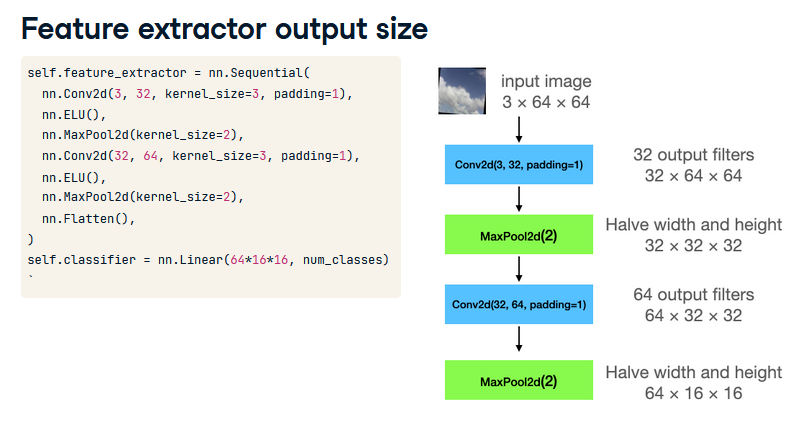

### [ 6 ] Training

In [ ]:
# Create our Model
model = Net(num_classes = 2).to(device)

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# Training Loop
num_epochs = 10
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print("Finished Training")

### [ 7 ] Evaluate the Model

```py
# Recall Examples
recall_per_class = Recall(task="multiclass", num_classes=num_classes, average=None)
recall_micro = Recall(task="multiclass", num_classes=num_classes, average="micro")
recall_macro = Recall(task="multiclass", num_classes=num_classes, average="macro")
recall_weighted = Recall(task="multiclass", num_classes=num_classes, average="weighted")
```

When to use each: 
- Micro: imbalanced dataset 
- Macro: Care about performance of each class
- Weighted: Consider errors in larger classes as more important

In [ ]:
# Setup Metrics
metric_precision = Precision(task="multiclass", num_classes=num_classes, average='macro')
metric_recall = Recall(task="multiclass", num_classes=num_classes, average='macro')
metric_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

# Evaluate the model
net.eval()

with torch.no_grad():
    for images, labels in dataloader_test:

        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, preds = torch.max(outputs, 1)

        metric_precision(preds, labels)
        metric_recall(preds, labels)
        metric_accuracy(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
accuracy = metric_accuracy.compute()

print(f"Precision = {precision}\n Recall = {recall}\nAccuracy = {accuracy}")

In [ ]:
# Setup Metrics
metric_precision = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average=None).to(device)
metric_recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average=None).to(device)
metric_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)

# Evaluate the model
net.eval()

# Dictionaries to store metrics for each class
per_class_precision = {}
per_class_recall = {}

with torch.no_grad():
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, preds = torch.max(outputs, 1)

        # Update the metrics for each batch
        metric_precision(preds, labels)
        metric_recall(preds, labels)
        metric_accuracy(preds, labels)

# Compute per-class metrics
precision = metric_precision.compute()
recall = metric_recall.compute()
accuracy = metric_accuracy.compute()

# Print per-class recall and precision
for class_name, class_index in dataset_test.class_to_idx.items():
    print({
        'class_name': class_name,
        'precision': precision[class_index].item(),
        'recall': recall[class_index].item()
    })

# Print overall accuracy
print(f"Overall Accuracy = {accuracy.item()}")